# 1. Summary
Develop a deep learning model for waste classification using the RealWaste dataset, which contains over 4,700 labeled images spanning 9 distinct waste categories (e.g., plastic, cardboard, metal). The goal is to automate waste sorting, improving efficiency and reducing manual labor.



# 2. Data import
Data link: https://archive.ics.uci.edu/dataset/908/realwaste

# 3. EDA

1.   Split the data
2.   Analyze the class distribution
3.   Apply normalization and resizing
4.   Data Augmentation if needed






In [ ]:
#Import library
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import collections
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import keras
from keras.regularizers import l2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix, ConfusionMatrixDisplay

#Import Data - only need to run this once and it will upload the dataset to colab
!wget -O realwaste.zip https://archive.ics.uci.edu/static/public/908/realwaste.zip
!unzip -q realwaste.zip -d realwaste_dataset

--2025-04-15 02:12:16--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [           <=>      ] 656.65M  5.06MB/s    in 2m 10s  

2025-04-15 02:14:29 (5.07 MB/s) - ‘realwaste.zip’ saved [688545323]



In [ ]:

#Read in Data from Zip
def load_waste_data(path_to_data, target_size=(64, 64)):
    images = []
    labels = []

    # Iterate over each class subfolder
    for label_name in os.listdir(path_to_data):
        label_folder = os.path.join(path_to_data, label_name)
        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                # We only want to process .jpg images
                if file_name.lower().endswith('.jpg'):
                    file_path = os.path.join(label_folder, file_name)
                    img = load_img(file_path, target_size=target_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(label_name)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

data_path = 'realwaste_dataset/realwaste-main/RealWaste'
images, labels = load_waste_data(data_path, target_size=(128, 128))
print("Loaded images shape:", images.shape)
print("Loaded labels shape:", labels.shape)
print("Unique labels:", np.unique(labels))


Loaded images shape: (4752, 128, 128, 3)
Loaded labels shape: (4752,)
Unique labels: ['Cardboard' 'Food Organics' 'Glass' 'Metal' 'Miscellaneous Trash' 'Paper'
 'Plastic' 'Textile Trash' 'Vegetation']


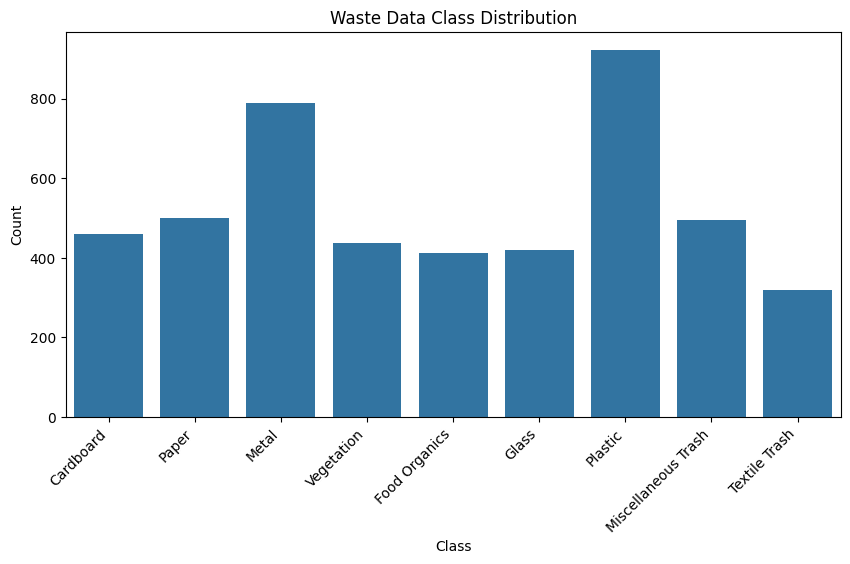

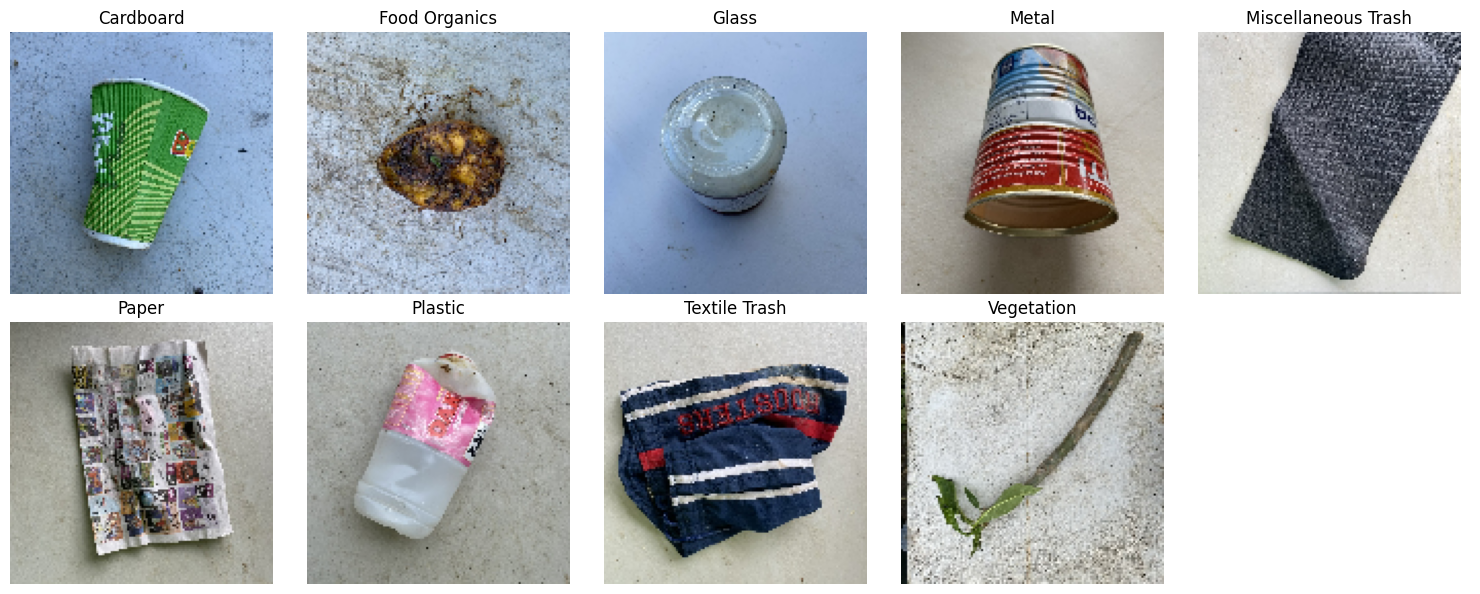

In [ ]:
#Plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=labels)
plt.title('Waste Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

#Plot sample images
unique_labels = np.unique(labels)
n = len(unique_labels)
n_cols = 5
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    index = np.where(labels == label)[0][0]
    axes[i].imshow(images[index] / 255.0)
    axes[i].set_title(label)
    axes[i].axis('off')
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Encoding
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
encoded_labels_classes = list(encoder.classes_)
print("Encoded labels sample:", encoded_labels[:10])
print("Label mapping:", encoded_labels_classes)

Encoded labels sample: [0 0 0 0 0 0 0 0 0 0]
Label mapping: [np.str_('Cardboard'), np.str_('Food Organics'), np.str_('Glass'), np.str_('Metal'), np.str_('Miscellaneous Trash'), np.str_('Paper'), np.str_('Plastic'), np.str_('Textile Trash'), np.str_('Vegetation')]


In [ ]:
def split_data(images, labels, splits, n_sample):

    # Set random seeds for reproducibility
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Shuffle the full dataset
    shuffle_indices = np.random.permutation(len(images))
    images = images[shuffle_indices]
    labels = labels[shuffle_indices]

    # Balance the classes: determine target count per class (up to 300 or the minimum count)
    unique_labels, counts = np.unique(labels, return_counts=True)
    target_count = min(n_sample, np.min(counts))

    balanced_indices = []
    for label in unique_labels:
        class_indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(class_indices, target_count, replace=False)
        balanced_indices.extend(selected_indices)
    balanced_indices = np.array(balanced_indices)

    # Create the balanced dataset
    images = images[balanced_indices]
    labels = labels[balanced_indices]

    # Shuffle the balanced dataset again for randomness
    shuffle_indices = np.random.permutation(len(images))
    images = images[shuffle_indices]
    labels = labels[shuffle_indices]

    # Create data splits (training, validation, and test sets)
    total_samples = len(images)
    train_size = int(splits[0] * total_samples)
    val_size = int(splits[1] * total_samples)

    X_train = images[:train_size]
    y_train = labels[:train_size]
    X_val   = images[train_size:train_size + val_size]
    y_val   = labels[train_size:train_size + val_size]
    X_test  = images[train_size + val_size:]
    y_test  = labels[train_size + val_size:]

    # Data augmentation on training data: apply both horizontal and vertical flips
    X_train_flip_lr = tf.image.flip_left_right(X_train)
    X_train_flip_ud = tf.image.flip_up_down(X_train)

    # Concatenate the original and augmented training data and labels
    X_train = tf.concat([X_train, X_train_flip_lr, X_train_flip_ud], axis=0)
    y_train = tf.concat([y_train, y_train, y_train], axis=0)

    # Shuffle the augmented training set ensuring both images and labels are shuffled in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy()
    y_train = tf.gather(y_train, shuffle).numpy()

    return X_train, y_train, X_val, y_val, X_test, y_test

split_ratios = (0.6, 0.2, 0.2)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split_ratios, 300)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4860, 128, 128, 3)
Validation set shape: (540, 128, 128, 3)
Test set shape: (540, 128, 128, 3)


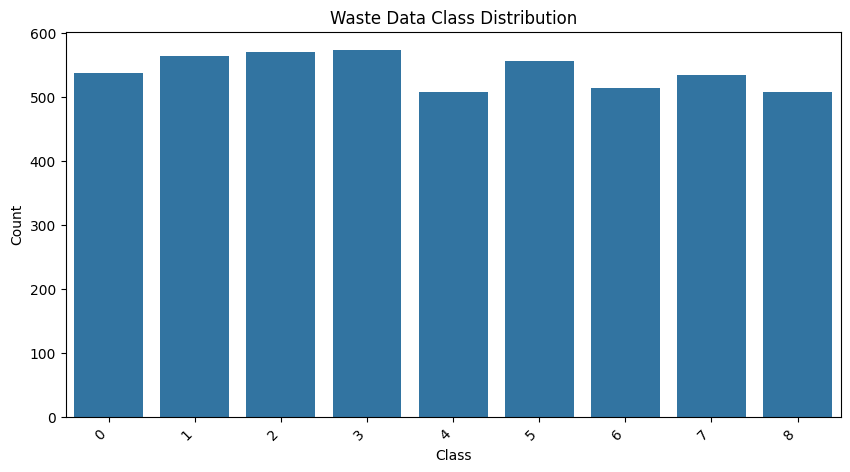

In [ ]:
#Plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Waste Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

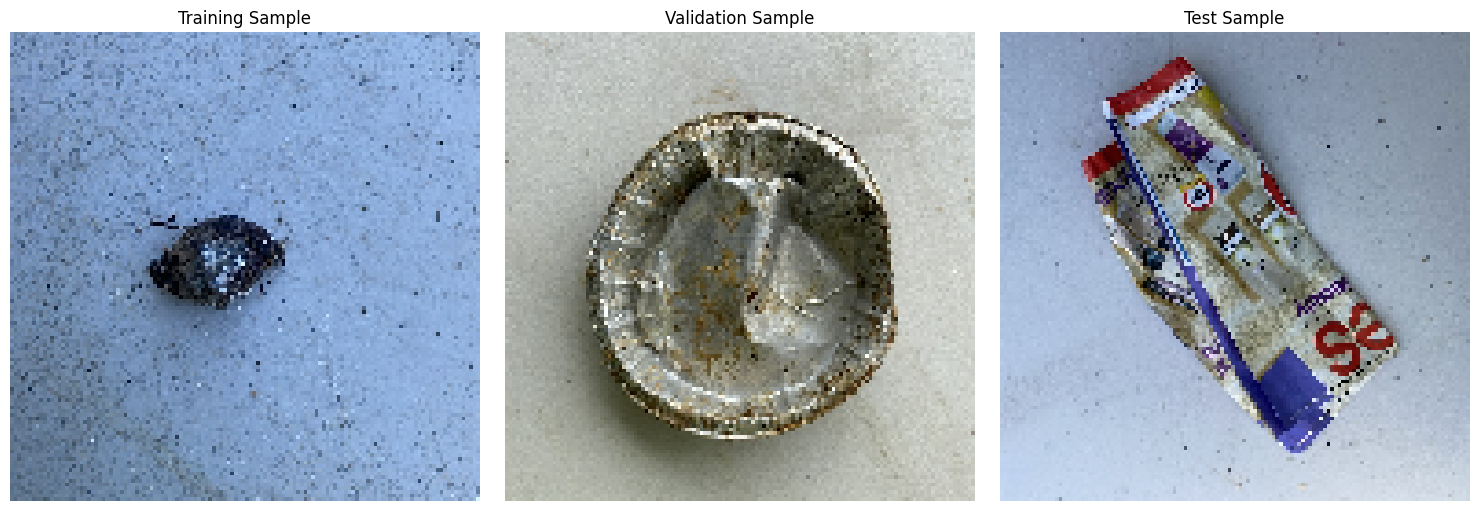

In [ ]:
# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization
X_train_norm = normalization_layer(X_train)
X_val_norm = normalization_layer(X_val)
X_test_norm = normalization_layer(X_test)

# Show sample images
plt.figure(figsize=(15, 5))

datasets = [("Training", X_train_norm), ("Validation", X_val_norm), ("Test", X_test_norm)]
for i, (name, dataset) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.imshow(dataset[0].numpy())
    plt.title(f"{name} Sample")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 4. Model Evaluation Function
Measure performance using accuracy, precision, recall, and confusion matrices to assess misclassification trends

In [ ]:
def evaluate_model_with_confusion_matrices(y_train, y_train_pred, y_val, y_val_pred, class_labels):
    """
    Evaluates the model's performance and displays confusion matrices for training and validation sets.

    Args:
        y_train: The true labels for the training set.
        y_train_pred: The predicted labels for the training set.
        y_val: The true labels for the validation set.
        y_val_pred: The predicted labels for the validation set.
        class_labels: A list of class labels for the confusion matrices.

    Returns:
        None (prints the results and displays the confusion matrices).
    """

    # Calculate and print accuracy, precision, and recall
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    train_precision = precision_score(y_train, y_train_pred, average='macro')
    val_precision = precision_score(y_val, y_val_pred, average='macro')
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    val_recall = recall_score(y_val, y_val_pred, average='macro')

    print('Training Accuracy: ', train_accuracy, 'Validation Accuracy: ', val_accuracy)
    print('Training Precision: ', train_precision, 'Validation Precision: ', val_precision)
    print('Training Recall: ', train_recall, 'Validation Recall: ', val_recall)

    # Create and display confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Training confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_labels)
    disp_train.plot(cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Training Confusion Matrix")
    axes[0].tick_params(axis='x', rotation=90)

    # Validation confusion matrix
    cm_val = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_labels)
    disp_val.plot(cmap=plt.cm.Blues, ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()


# 5. Baseline Model



1.   Decision Tree
2.   Majority class predictor
3.   Shallow CNN



## 5.1 Decision Tree

Reshape the training, validation, and test data to be compatible with the Sklearn Decision Tree

In [ ]:
# Reshape the training, validation, and test data to be compatible with the Sklearn Decision Tree
X_train_flat = tf.reshape(X_train_norm,(X_train.shape[0], -1))
X_val_flat = tf.reshape(X_val_norm, (X_val.shape[0], -1))
X_test_flat = tf.reshape(X_test_norm,(X_test.shape[0], -1))

# Print shapes
print('Shape of train images ', X_train_flat.shape)
print('Shape of val images ', X_val_flat.shape)
print('Shape of test images ', X_test_flat.shape)

Shape of train images  (4860, 12288)
Shape of val images  (540, 12288)
Shape of test images  (540, 12288)


Build up the Model

In [ ]:
def build_model_decisiontree(X_train, y_train, X_val, X_test, **kwargs):
    """
    Builds and trains a Decision Tree Classifier model.

    Args:
        X_train: Training data features.
        y_train: Training data labels.
        X_val: Validation data features.
        X_test: Test data features.
        **kwargs: Keyword arguments for the DecisionTreeClassifier.

    Returns:
        y_train_pred: Predicted labels for the training set.
        y_val_pred: Predicted labels for the validation set.
        y_test_pred: Predicted labels for the test set.
    """

    # Create a Decision Tree Classifier with provided parameters
    clf = tree.DecisionTreeClassifier(**kwargs)

    # Fit the model to the training data
    clf.fit(X_train, y_train)

    # Make predictions on the training, validation, and test sets
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)

    plt.figure(figsize=(20, 10))  # Adjust figure size as needed
    tree.plot_tree(clf,
          class_names=encoded_labels_classes,  # Provide class names
          filled=True,
          rounded=True,
          fontsize=8)  # Adjust font size as needed

    plt.savefig('decision_tree.png')
    plt.show()

    return y_train_pred, y_val_pred, y_test_pred

Model build up and Evaluation

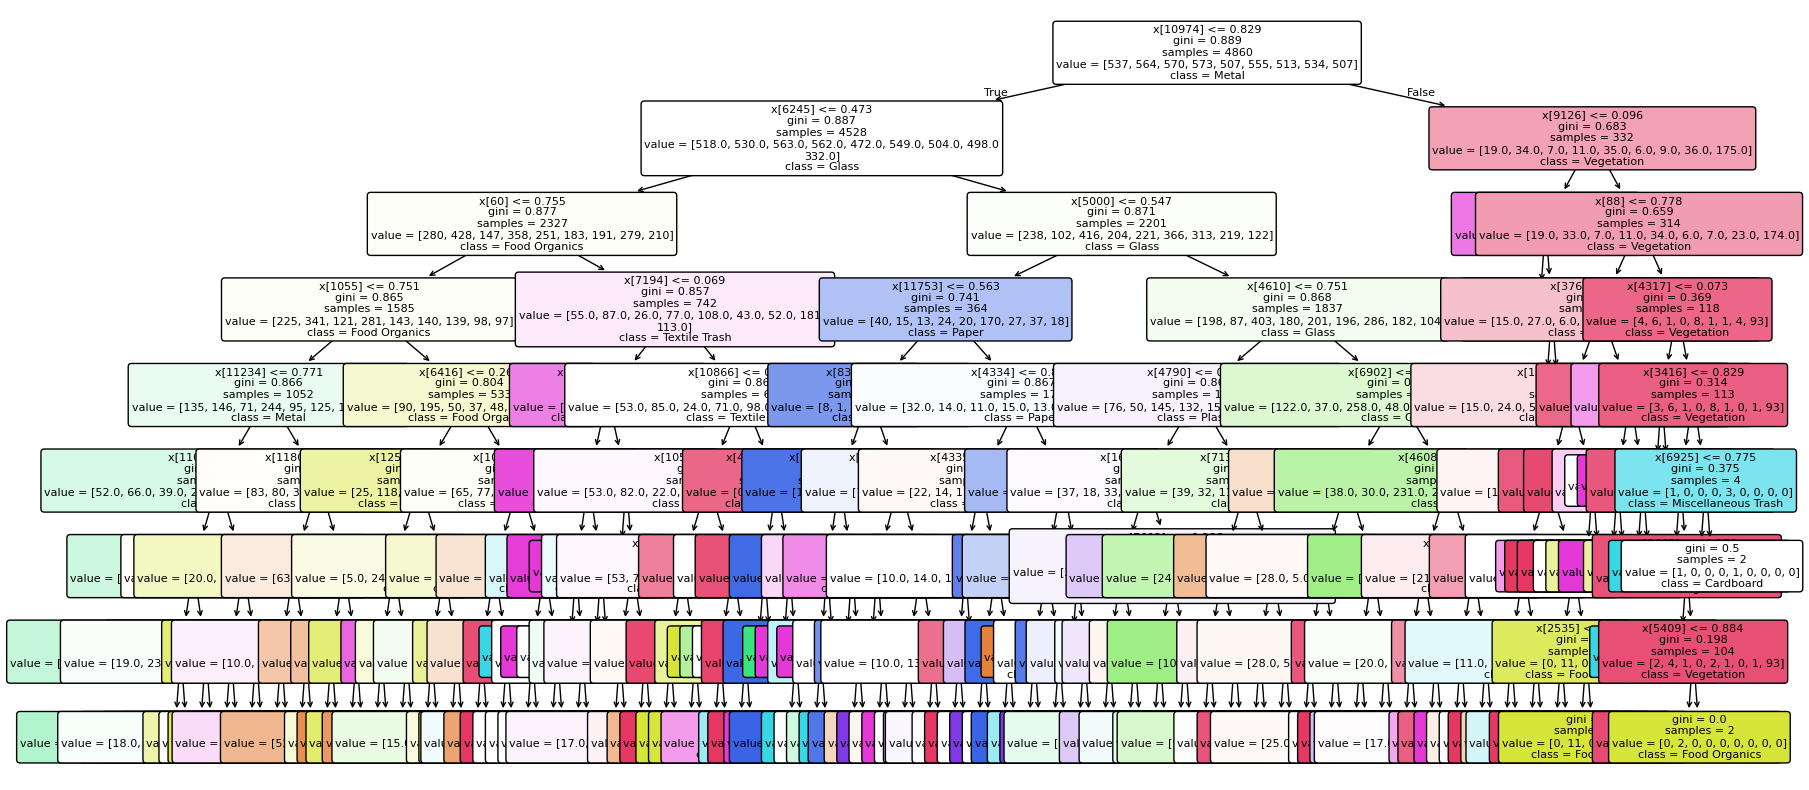

Training Accuracy:  0.5164609053497943 Validation Accuracy:  0.31666666666666665
Training Precision:  0.5350708334473052 Validation Precision:  0.3253150313315556
Training Recall:  0.514610376548941 Validation Recall:  0.3188870889575931


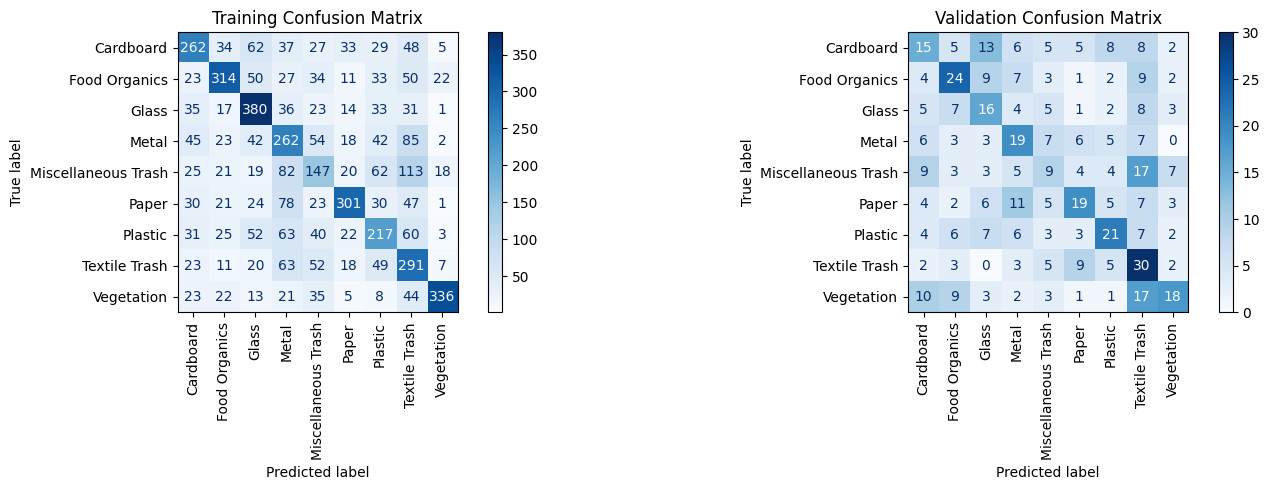

In [ ]:
y_train_pred, y_val_pred, y_test_pred = build_model_decisiontree(X_train_flat, y_train, X_val_flat, X_test_flat, random_state=1234, max_depth=8,min_samples_leaf=2)
evaluate_model_with_confusion_matrices(y_train, y_train_pred, y_val, y_val_pred, encoded_labels_classes)

# 6. Final Model
Experiment with deeper CNN architectures (e.g., ResNet, EfficientNet) and optimize hyperparameters (batch size, learning rate, optimizer selection).


In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)

    return x

In [ ]:
def resnet_v2(input_shape, depth, num_classes=9):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')

    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:
                    strides = 2

            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def lr_schedule(epoch):
    lr = 2e-4
    if epoch >= 2:
      lr = 1e-4
    if epoch >= 10:
      lr *= 1e-1
    if epoch >= 15:
      lr *= 1e-2
    elif epoch >= 20:
        lr *= 1e-3
    print('Learning rate: ', lr)
    return lr

In [ ]:
tf.keras.backend.clear_session()

model = resnet_v2(input_shape=(128, 128, 3), depth=20)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
							   cooldown=0,
							   patience=5,
							   min_lr=0.5e-6)

callbacks = [ lr_reducer, lr_scheduler]

model.compile(loss='sparse_categorical_crossentropy',
			  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
			  metrics=['accuracy'])
model.summary()

Learning rate:  0.0002


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        272 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,320 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      1,088 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      1,088 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ add[0][0]         │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      1,040 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_5[0][0]  

 Total params: 608,393 (2.32 MB)

 Trainable params: 604,905 (2.31 MB)

 Non-trainable params: 3,488 (13.62 KB)

In [ ]:
model.fit(X_train_norm, y_train,
			  batch_size=15,
			  epochs=20,
			  validation_data=(X_val_norm, y_val), callbacks=callbacks)

Learning rate:  0.0002
Epoch 1/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 1459s 4s/step - accuracy: 0.3958 - loss: 2.1445 - val_accuracy: 0.5796 - val_loss: 1.6692 - learning_rate: 2.0000e-04
Learning rate:  0.0002
Epoch 2/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 1436s 4s/step - accuracy: 0.5941 - loss: 1.5727 - val_accuracy: 0.6685 - val_loss: 1.3911 - learning_rate: 2.0000e-04
Learning rate:  0.0001
Epoch 3/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 1460s 4s/step - accuracy: 0.6763 - loss: 1.3707 - val_accuracy: 0.6889 - val_loss: 1.3055 - learning_rate: 1.0000e-04
Learning rate:  0.0001
Epoch 4/20
 21/324 ━━━━━━━━━━━━━━━━━━━━ 21:19 4s/step - accuracy: 0.6847 - loss: 1.3805

In [ ]:
model.fit(X_train_norm, y_train,
			  batch_size=30,
			  epochs=20,
			  validation_data=(X_val_norm, y_val), callbacks=callbacks)

Learning rate:  0.0002
Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 892s 5s/step - accuracy: 0.3696 - loss: 2.1497 - val_accuracy: 0.2537 - val_loss: 2.6200 - learning_rate: 2.0000e-04
Learning rate:  0.0002
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 918s 5s/step - accuracy: 0.5839 - loss: 1.5931 - val_accuracy: 0.4889 - val_loss: 1.8145 - learning_rate: 2.0000e-04
Learning rate:  0.0001
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 905s 5s/step - accuracy: 0.6616 - loss: 1.4144 - val_accuracy: 0.6463 - val_loss: 1.4427 - learning_rate: 1.0000e-04
Learning rate:  0.0001
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 858s 5s/step - accuracy: 0.6915 - loss: 1.3377 - val_accuracy: 0.6685 - val_loss: 1.4000 - learning_rate: 1.0000e-04
Learning rate:  0.0001
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 869s 5s/step - accuracy: 0.7164 - loss: 1.2828 - val_accuracy: 0.6759 - val_loss: 1.3827 - learning_rate: 1.0000e-04
Learning rate:  0.0001
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 935s 5s/step - accuracy: 0.7307 - los

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)
tf.keras.backend.clear_session()

# initialize model
model_tf = tf.keras.Sequential()


# add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(24, kernel_size=3, padding="same", strides=(1,1),
                           activation="relu", kernel_initializer="he_normal", data_format = 'channels_last'))

model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model_tf.add(tf.keras.layers.Conv2D(48, kernel_size=3, padding="same", strides=(1,1),
                           activation="relu", kernel_initializer="he_normal", data_format = 'channels_last'))
# add max pooling layer
model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model_tf.add(tf.keras.layers.Conv2D(96, kernel_size=3, padding="same", strides=(1,1),
                           activation="relu", kernel_initializer="he_normal", data_format = 'channels_last'))

# add max pooling layer
model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model_tf.add(tf.keras.layers.Conv2D(192, kernel_size=3, padding="same", strides=(1,1),
                           activation="relu", kernel_initializer="he_normal", data_format = 'channels_last'))

model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model_tf.add(tf.keras.layers.Conv2D(384, kernel_size=3, padding="same", strides=(1,1),
                           activation="relu", kernel_initializer="he_normal", data_format = 'channels_last'))

model_tf.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

model_tf.add(tf.keras.layers.Dense(256, activation='relu'))

# add the classification layer
model_tf.add(tf.keras.layers.Dense(9, activation='softmax'))

# build and compile model
model_tf.build(input_shape=(None, 128, 128, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
model_tf.summary()




(array([537., 564., 570., 573.,   0., 507., 555., 513., 534., 507.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

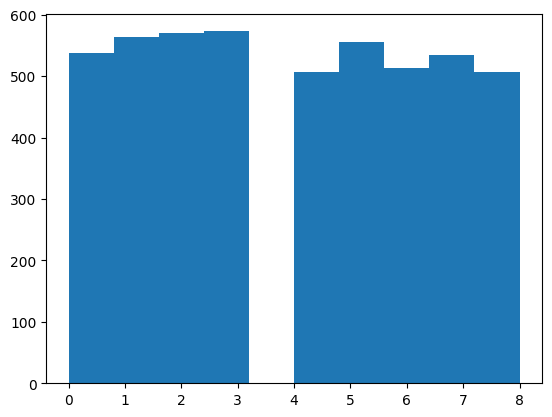

In [ ]:
plt.hist(y_train)

In [ ]:
history = model_tf.fit(X_train_norm, y_train, epochs=20, validation_data=(X_val_norm, y_val))


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 338ms/step - accuracy: 0.1197 - loss: 4.0982 - val_accuracy: 0.2000 - val_loss: 2.1822
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 52s 343ms/step - accuracy: 0.1618 - loss: 2.1417 - val_accuracy: 0.3056 - val_loss: 1.8456
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 338ms/step - accuracy: 0.2969 - loss: 1.8806 - val_accuracy: 0.2741 - val_loss: 1.7946
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 335ms/step - accuracy: 0.3482 - loss: 1.7409 - val_accuracy: 0.3000 - val_loss: 1.7488
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 332ms/step - accuracy: 0.4010 - loss: 1.6237 - val_accuracy: 0.3667 - val_loss: 1.6213
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 348ms/step - accuracy: 0.4555 - loss: 1.4984 - val_accuracy: 0.4481 - val_loss: 1.4764
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 336ms/step - accuracy: 0.4956 - loss: 1.3932 - val_accuracy: 0.4537 - val_loss: 1.4360
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 51s 334ms/step - accuracy: 0.5082 - loss: 1

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)
#tf.keras.backend.clear_session()

# initialize model
model_tf_simple = tf.keras.Sequential()


# add convolutional layer
model_tf_simple.add(tf.keras.layers.Conv2D(24, kernel_size=4, padding="same", strides=(1,1),
                           activation="relu", kernel_initializer="he_normal", data_format = 'channels_last'))

model_tf_simple.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model_tf_simple.add(tf.keras.layers.Dropout(0.25))

# add a flattening layer
model_tf_simple.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf_simple.add(tf.keras.layers.Dense(9, activation='softmax'))

# build and compile model
model_tf_simple.build(input_shape=(None, 64, 64, 3))
model_tf_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# print model_tf summary
model_tf_simple.summary()

history = model_tf_simple.fit(X_train_norm, y_train, epochs=2, validation_data=(X_val_norm, y_val))



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 24)          │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 24576)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │         221,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,369 (868.63 KB)

 Trainable params: 222,369 (868.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.1653 - loss: 12.4608 - val_accuracy: 0.2389 - val_loss: 2.0634
Epoch 2/2
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.3597 - loss: 1.7830 - val_accuracy: 0.3167 - val_loss: 1.9075


152/152 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training Accuracy:  0.4849794238683128 Validation Accuracy:  0.31666666666666665
Training Precision:  0.5208449549628364 Validation Precision:  0.31960577559898445
Training Recall:  0.48230763259715065 Validation Recall:  0.323558578585098


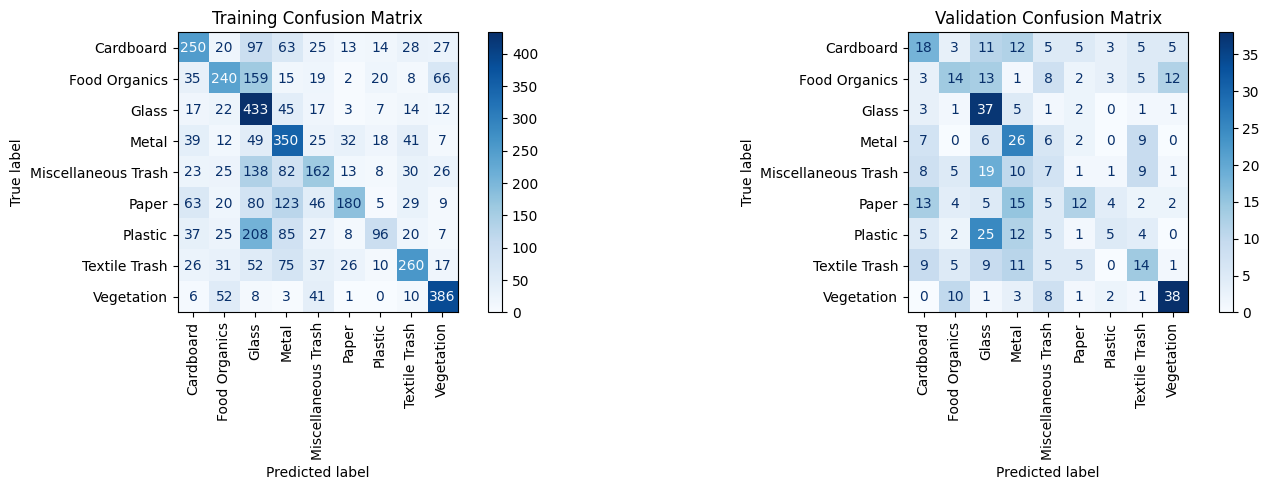

In [ ]:
y_train_pred= model_tf_simple.predict(X_train_norm).argmax(axis=1)
y_val_pred= model_tf_simple.predict(X_val_norm).argmax(axis=1)
evaluate_model_with_confusion_matrices(y_train, y_train_pred, y_val, y_val_pred, encoded_labels_classes)

In [ ]:
y_train_pred.argmax(axis=1)

array([1, 2, 1, ..., 2, 4, 5])

# 7. Evaluation
